In [1]:
import pandas as pd
import numpy as np
import torch
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from torch import nn

In [2]:
df = pd.read_csv('dftrain0420.csv')
df112 = pd.read_csv('dfvalid0420.csv')

df = df.drop(['Unnamed: 0','土地位置建物門牌','交易年月日','建築完成年月',
             'new_date','address','longitude','latitude'],axis=1)

df112 = df112.drop(['Unnamed: 0','土地位置建物門牌','交易年月日','建築完成年月',
             'new_date','address','longitude','latitude'],axis=1)

In [3]:
x = df.drop(['總價元'], axis=1)
y = df['總價元']

valid_labels = df112.drop(['總價元'], axis=1)
valid_target = df112['總價元']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.25, random_state=42)

In [4]:
scaler = StandardScaler().fit(x_train)
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)
x_val = scaler.transform(x_val)

In [5]:
def compute_errors_print(y, pred):
    
    mse = mean_squared_error(y, pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, pred)
    
    error_names = ['RMSE', 'R^2']
    errors = [rmse, r2]
    
    for name, error in zip(error_names, errors):
        print(f'{name} : {error:.6f}')

In [6]:
def compute_errors(y, pred):
    
    mse = mean_squared_error(y, pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y, pred)

    return rmse, r2

In [7]:
#　梯度下降
def compute_error(x, y, w, b):
    y_pred = x @ w + b
    errors = y - y_pred
    rmse = np.sqrt(np.mean(errors**2))
    r2 = 1 - np.sum(errors**2) / np.sum((y - np.mean(y))**2)
    return rmse, r2

def compute_grad(x, y, w, b):
    y_pred = x @ w + b
    errors = y - y_pred
    w_grad = x.T @ (-errors) / x.shape[0]
    b_grad = np.mean(-errors)
    return w_grad, b_grad

def gradient_descent(x1, x2, y1, y2, w, b, alpha, run_iter):

    train_rmses = []
    val_rmses = []

    for _ in range(run_iter+1):
        
        w_grad, b_grad = compute_grad(x1, y1, w, b)

        w -= alpha*w_grad
        b -= alpha*b_grad

        train_rmse = compute_error(x1, y1, w, b)[0]
        val_rmse = compute_error(x2, y2, w, b)[0]

        train_rmses.append(train_rmse)
        val_rmses.append(val_rmse)
        
    return w, b, train_rmses, val_rmses
    

In [8]:
alpha = 0.01
run_iter = 10000
w1 = np.zeros(x_train.shape[1])
b1 = 0

e1w, e1b, train_rmses1, val_rmses1 = gradient_descent(x_train, x_val,
                                        y_train, y_val,
                                        w1, b1,
                                        alpha, run_iter)



In [9]:
evaluate_name = ['RMSE', 'R^2']
print('Train Error')
for name, error in zip(evaluate_name, compute_error(x_train, y_train, e1w , e1b)):
    print(f'{name} : {error:.6f}')
print('--------------------------------')
print('Test Error')
for name, error in zip(evaluate_name, compute_error(x_test, y_test, e1w , e1b)):
    print(f'{name} : {error:.6f}')
print('--------------------------------')
print('Valid Error')
for name, error in zip(evaluate_name, compute_error(x_val, y_val, e1w , e1b)):
    print(f'{name} : {error:.6f}')

Train Error
RMSE : 240.152104
R^2 : 0.706530
--------------------------------
Test Error
RMSE : 232.262845
R^2 : 0.727008
--------------------------------
Valid Error
RMSE : 235.514536
R^2 : 0.719241


In [10]:
# 決策樹迴歸
tree_model1 = DecisionTreeRegressor(random_state=42).fit(x_train, y_train)
tree_pred1 = tree_model1.predict(x_test)
tree_val_pred1 = tree_model1.predict(x_val)

In [11]:
print('Test Error')
compute_errors_print(y_test, tree_pred1)
print('--------------------------------')
print('Valid Error') 
compute_errors_print(y_val, tree_val_pred1)

Test Error
RMSE : 233.213284
R^2 : 0.724769
--------------------------------
Valid Error
RMSE : 227.681914
R^2 : 0.737605


In [12]:
# 隨機森林迴歸
forest_model1 = RandomForestRegressor(random_state=42).fit(x_train, y_train)
forest_pred1 = forest_model1.predict(x_test)
forest_val_pred1 = forest_model1.predict(x_val)

In [13]:
print('Test Error')
compute_errors_print(y_test, forest_pred1)
print('--------------------------------')
print('Valid Error') 
compute_errors_print(y_val, forest_val_pred1)

Test Error
RMSE : 164.568875
R^2 : 0.862948
--------------------------------
Valid Error
RMSE : 162.001809
R^2 : 0.867157


In [14]:
# 支援向量迴歸
svr_model1 = SVR().fit(x_train, y_train)
svr_pred1 = svr_model1.predict(x_test)
svr_val_pred1 = svr_model1.predict(x_val)

In [15]:
print('Test Error')
compute_errors_print(y_test, svr_pred1)
print('--------------------------------')
print('Valid Error') 
compute_errors_print(y_val, svr_val_pred1)

Test Error
RMSE : 252.492223
R^2 : 0.677384
--------------------------------
Valid Error
RMSE : 253.881837
R^2 : 0.673741


In [16]:
class MultipleLinearRegressionModel(nn.Module):
    def __init__(self, input_shape, hidden_layers=[128, 64, 32], dropout_rate=0.5, learning_rate=0.01):
        super(MultipleLinearRegressionModel, self).__init__()
        self.input_shape = input_shape
        self.hidden_layers = hidden_layers
        self.dropout_rate = dropout_rate
        self.learning_rate = learning_rate

        layers = []
        in_features = input_shape
        for hidden_units in hidden_layers:
            layers.append(nn.Linear(in_features, hidden_units))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            in_features = hidden_units
        
        layers.append(nn.Linear(in_features, 1))
        
        self.model = nn.Sequential(*layers)
        self.cost_fn = nn.MSELoss()
        self.optimizer = torch.optim.AdamW(self.model.parameters(), lr=learning_rate)
        self.scaler_y = StandardScaler()

    def forward(self, x):
        return self.model(x)

    def preprocess_data(self, x, y=None, fit_scaler=False):
        x_tensor = torch.tensor(x, dtype=torch.float32)
        if y is not None:
            y = y.to_numpy().reshape(-1, 1)
            if fit_scaler:
                y = self.scaler_y.fit_transform(y)
            else:
                y = self.scaler_y.transform(y)
            y_tensor = torch.tensor(y, dtype=torch.float32)
            return x_tensor, y_tensor
        return x_tensor

    def fit(self, x_train, y_train, x_val, y_val, epochs=10000, print_every=1000):
        x_train_tensor, y_train_tensor = self.preprocess_data(x_train, y_train, fit_scaler=True)
        x_val_tensor, y_val_tensor = self.preprocess_data(x_val, y_val)

        for epoch in range(epochs+1):
            self.train()
            train_pred = self(x_train_tensor)
            train_cost = self.cost_fn(train_pred, y_train_tensor)

            self.optimizer.zero_grad()
            train_cost.backward()
            self.optimizer.step()

            self.eval()
            with torch.inference_mode():
                val_pred = self(x_val_tensor)
                val_cost = self.cost_fn(val_pred, y_val_tensor)

            if epoch % print_every == 0:
                print(f'Epoch [{epoch}/{epochs}] : Train Loss = {train_cost.item():.6f} ; Val Loss = {val_cost.item():.6f}')
            
        print(f'==================================================')
        print(f'Final Train Loss = {train_cost.item():.6f} ; Val Loss = {val_cost.item():.6f}')

        return train_cost.item(), val_cost.item()

    def evaluate(self, x_test, y_test, x_val, y_val):
        x_test_tensor, y_test_tensor = self.preprocess_data(x_test, y_test)
        x_val_tensor, y_val_tensor = self.preprocess_data(x_val, y_val)

        self.eval()
        with torch.inference_mode():
            test_pred = self(x_test_tensor)
            val_pred = self(x_val_tensor)
            test_cost = self.cost_fn(test_pred, y_test_tensor)
            val_cost = self.cost_fn(val_pred, y_val_tensor)

        print(f'Final Test Loss = {test_cost.item():.6f}')
        print(f'Final Valid Loss = {val_cost.item():.6f}')

        y_test_np = self.scaler_y.inverse_transform(y_test_tensor.numpy())
        test_pred_np = self.scaler_y.inverse_transform(test_pred.numpy())
        y_val_np = self.scaler_y.inverse_transform(y_val_tensor.numpy())
        val_pred_np = self.scaler_y.inverse_transform(val_pred.numpy())

        nn_test_rmse = np.sqrt(np.mean((y_test_np - test_pred_np)**2))
        nn_val_rmse = np.sqrt(np.mean((y_val_np - val_pred_np)**2))

        return nn_test_rmse, nn_val_rmse 

    def predict(self, X):
        X_tensor = self.preprocess_data(X)
        self.eval()
        with torch.inference_mode():
            pred = self(X_tensor)
        return self.scaler_y.inverse_transform(pred.numpy())

In [17]:
nn_model1 = MultipleLinearRegressionModel(input_shape=x_train.shape[1])
nn_model1.fit(x_train, y_train, x_val, y_val, epochs=10000, print_every=1000)
nn_test_rmse1, nn_val_rmse1 = nn_model1.evaluate(x_test, y_test, x_val, y_val) 

Epoch [0/10000] : Train Loss = 0.999388 ; Val Loss = 0.855403
Epoch [1000/10000] : Train Loss = 0.224670 ; Val Loss = 0.164081
Epoch [2000/10000] : Train Loss = 0.219911 ; Val Loss = 0.160158
Epoch [3000/10000] : Train Loss = 0.215156 ; Val Loss = 0.162425
Epoch [4000/10000] : Train Loss = 0.214164 ; Val Loss = 0.155940
Epoch [5000/10000] : Train Loss = 0.213438 ; Val Loss = 0.156493
Epoch [6000/10000] : Train Loss = 0.215455 ; Val Loss = 0.157374
Epoch [7000/10000] : Train Loss = 0.212239 ; Val Loss = 0.157781
Epoch [8000/10000] : Train Loss = 0.210684 ; Val Loss = 0.159787
Epoch [9000/10000] : Train Loss = 0.215704 ; Val Loss = 0.162613
Epoch [10000/10000] : Train Loss = 0.208742 ; Val Loss = 0.153293
Final Train Loss = 0.208742 ; Val Loss = 0.153293
Final Test Loss = 0.161950
Final Valid Loss = 0.153293


In [18]:
def plot(model_names, test_rmses, val_rmses):
    plt.plot(model_names, test_rmses, color='blue', marker='o', label='Test RMSE')
    plt.plot(model_names, val_rmses, color='orange', marker='o', label='Valid RMSE')
    plt.xlabel('Model Names')
    plt.ylabel('RMSE')
    plt.title('Comparison of Models')
    plt.xticks(rotation=15, ha='right')
    plt.legend()
    plt.tight_layout()
    plt.show()

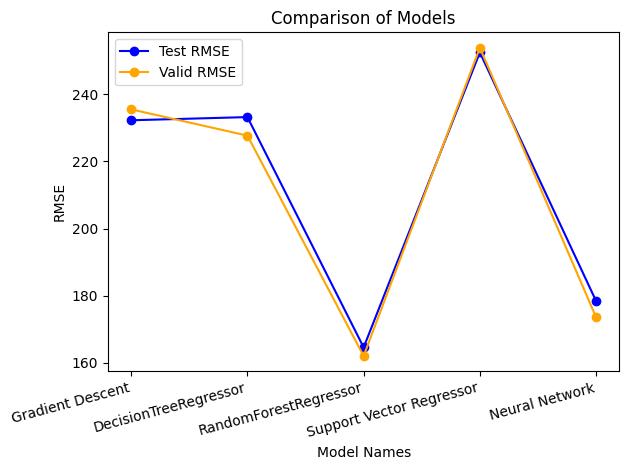

In [19]:
model_names = ['Gradient Descent', 'DecisionTreeRegressor', 'RandomForestRegressor', 'Support Vector Regressor', 'Neural Network']
gd_test_rmse1, gd_val_rmse1 = compute_error(x_test, y_test, e1w , e1b)[0], compute_error(x_val, y_val, e1w , e1b)[0]
tree_test_rmse1, tree_val_rmse1 = compute_errors(y_test, tree_pred1)[0], compute_errors(y_val, tree_val_pred1)[0]
forest_test_rmse1, forest_val_rmse1 = compute_errors(y_test, forest_pred1)[0], compute_errors(y_val, forest_val_pred1)[0]
svr_test_rmse1, svr_val_rmse1 = compute_errors(y_test, svr_pred1)[0], compute_errors(y_val, svr_val_pred1)[0]

test_rmses1 = [gd_test_rmse1, tree_test_rmse1, forest_test_rmse1, svr_test_rmse1, nn_test_rmse1]
val_rmses1 = [gd_val_rmse1, tree_val_rmse1, forest_val_rmse1, svr_val_rmse1, nn_val_rmse1]

plot(model_names, test_rmses1, val_rmses1)

In [20]:
featue_importances = forest_model1.feature_importances_
median_featue_importances = np.median(featue_importances)

x_train_new = x_train[:, featue_importances >= median_featue_importances]
x_test_new = x_test[:, featue_importances >= median_featue_importances]
x_val_new = x_val[:, featue_importances >= median_featue_importances]

In [21]:
alpha = 0.01
run_iter = 10000
w2 = np.zeros(x_train_new.shape[1])
b2 = 0
e2w, e2b, train_rmses2, val_rmses2 = gradient_descent(x_train_new, x_val_new,
                                        y_train, y_val,
                                        w2, b2,
                                        alpha, run_iter)

In [22]:
evaluate_name = ['RMSE', 'R^2']
print('Train Error')
for name, error in zip(evaluate_name, compute_error(x_train_new, y_train, e2w , e2b)):
    print(f'{name} : {error:.6f}')
print('--------------------------------')
print('Test Error')
for name, error in zip(evaluate_name, compute_error(x_test_new, y_test, e2w , e2b)):
    print(f'{name} : {error:.6f}')
print('--------------------------------')
print('Valid Error')
for name, error in zip(evaluate_name, compute_error(x_val_new, y_val, e2w , e2b)):
    print(f'{name} : {error:.6f}')

Train Error
RMSE : 267.007833
R^2 : 0.637223
--------------------------------
Test Error
RMSE : 258.395278
R^2 : 0.662122
--------------------------------
Valid Error
RMSE : 261.178912
R^2 : 0.654717


In [23]:
tree_model2 = DecisionTreeRegressor(random_state=42).fit(x_train_new, y_train)
tree_pred2 = tree_model2.predict(x_test_new)
tree_val_pred2 = tree_model2.predict(x_val_new)

In [24]:
print('Test Error')
compute_errors_print(y_test, tree_pred2)
print('--------------------------------')
print('Valid Error') 
compute_errors_print(y_val, tree_val_pred2)

Test Error
RMSE : 235.315390
R^2 : 0.719785
--------------------------------
Valid Error
RMSE : 233.451993
R^2 : 0.724137


In [25]:
forest_model2 = RandomForestRegressor(random_state=42).fit(x_train_new, y_train)
forest_pred2 = forest_model2.predict(x_test_new)
forest_val_pred2 = forest_model2.predict(x_val_new)

In [26]:
print('Test Error')
compute_errors_print(y_test, forest_pred2)
print('--------------------------------')
print('Valid Error') 
compute_errors_print(y_val, forest_val_pred2)

Test Error
RMSE : 168.316809
R^2 : 0.856634
--------------------------------
Valid Error
RMSE : 166.094951
R^2 : 0.860359


In [27]:
svr_model2 = SVR().fit(x_train_new, y_train)
svr_pred2 = svr_model2.predict(x_test_new)
svr_val_pred2 = svr_model2.predict(x_val_new)

In [28]:
print('Test Error')
compute_errors_print(y_test, svr_pred2)
print('--------------------------------')
print('Valid Error') 
compute_errors_print(y_val, svr_val_pred2)

Test Error
RMSE : 243.192237
R^2 : 0.700712
--------------------------------
Valid Error
RMSE : 243.782654
R^2 : 0.699182


In [30]:
nn_model2 = MultipleLinearRegressionModel(input_shape=x_train_new.shape[1])
nn_model2.fit(x_train_new, y_train, x_val_new, y_val, epochs=10000, print_every=1000)
nn_test_rmse2, nn_val_rmse2 = nn_model2.evaluate(x_test_new, y_test, x_val_new, y_val) 

Epoch [0/10000] : Train Loss = 1.006903 ; Val Loss = 0.858435
Epoch [1000/10000] : Train Loss = 0.244416 ; Val Loss = 0.173519
Epoch [2000/10000] : Train Loss = 0.235692 ; Val Loss = 0.173269
Epoch [3000/10000] : Train Loss = 0.236638 ; Val Loss = 0.172179
Epoch [4000/10000] : Train Loss = 0.231082 ; Val Loss = 0.169572
Epoch [5000/10000] : Train Loss = 0.229501 ; Val Loss = 0.167808
Epoch [6000/10000] : Train Loss = 0.230433 ; Val Loss = 0.167379
Epoch [7000/10000] : Train Loss = 0.228706 ; Val Loss = 0.168284
Epoch [8000/10000] : Train Loss = 0.230372 ; Val Loss = 0.166703
Epoch [9000/10000] : Train Loss = 0.230996 ; Val Loss = 0.164372
Epoch [10000/10000] : Train Loss = 0.228695 ; Val Loss = 0.166144
Final Train Loss = 0.228695 ; Val Loss = 0.166144
Final Test Loss = 0.171983
Final Valid Loss = 0.166144


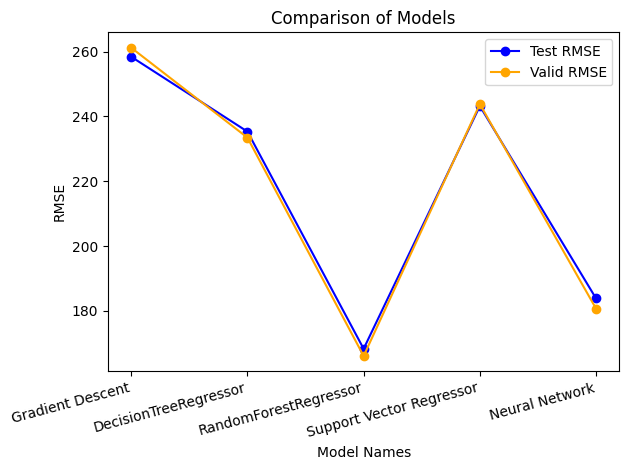

In [31]:
gd_test_rmse2, gd_val_rmse2 = compute_error(x_test_new, y_test, e2w , e2b)[0], compute_error(x_val_new, y_val, e2w , e2b)[0]
tree_test_rmse2, tree_val_rmse2 = compute_errors(y_test, tree_pred2)[0], compute_errors(y_val, tree_val_pred2)[0]
forest_test_rmse2, forest_val_rmse2 = compute_errors(y_test, forest_pred2)[0], compute_errors(y_val, forest_val_pred2)[0]
svr_test_rmse2, svr_val_rmse2 = compute_errors(y_test, svr_pred2)[0], compute_errors(y_val, svr_val_pred2)[0]

test_rmses2 = [gd_test_rmse2, tree_test_rmse2, forest_test_rmse2, svr_test_rmse2, nn_test_rmse2]
val_rmses2 = [gd_val_rmse2, tree_val_rmse2, forest_val_rmse2, svr_val_rmse2, nn_val_rmse2]

plot(model_names, test_rmses2, val_rmses2)

In [32]:
alpha = 0.053
run_iter = 4000
w3 = np.zeros(x_train_new.shape[1])
b3 = 0

e3w , e3b, train_rmses3, val_rmses3 = gradient_descent(x_train_new, x_val_new, y_train, y_val, w3, b3, alpha, run_iter)

In [33]:
evaluate_name = ['RMSE', 'R^2']
print('Train Error')
for name, error in zip(evaluate_name, compute_error(x_train_new, y_train, e3w , e3b)):
    print(f'{name} : {error:.6f}')
print('--------------------------------')
print('Test Error')
for name, error in zip(evaluate_name, compute_error(x_test_new, y_test, e3w , e3b)):
    print(f'{name} : {error:.6f}')
print('--------------------------------')
print('Valid Error')
for name, error in zip(evaluate_name, compute_error(x_val_new, y_val, e3w , e3b)):
    print(f'{name} : {error:.6f}')

Train Error
RMSE : 267.007833
R^2 : 0.637223
--------------------------------
Test Error
RMSE : 258.395228
R^2 : 0.662122
--------------------------------
Valid Error
RMSE : 261.178905
R^2 : 0.654717


In [34]:
tree_model3 = DecisionTreeRegressor(criterion='poisson',
                                     splitter='best',
                                     max_depth=48,
                                     min_samples_leaf=25,
                                     min_samples_split=25,
                                     max_features=12,
                                     random_state=42,
                                    ).fit(x_train_new, y_train)
tree_pred3 = tree_model3.predict(x_test_new)
tree_val_pred3 = tree_model3.predict(x_val_new)

In [35]:
print('Test Error')
compute_errors_print(y_test, tree_pred3)
print('--------------------------------')
print('Valid Error') 
compute_errors_print(y_val, tree_val_pred3)

Test Error
RMSE : 195.932020
R^2 : 0.805732
--------------------------------
Valid Error
RMSE : 193.454724
R^2 : 0.810566


In [36]:
forest_model3 = RandomForestRegressor(criterion='squared_error',
                                     max_depth=None,
                                     max_features='log2',
                                     min_samples_leaf=1,
                                     min_samples_split=2,
                                     n_estimators=540,
                                     random_state=42).fit(x_train_new, y_train)
forest_pred3 = forest_model3.predict(x_test_new)
forest_val_pred3 = forest_model3.predict(x_val_new)

In [37]:
print('Test Error')
compute_errors_print(y_test, forest_pred3)
print('--------------------------------')
print('Valid Error') 
compute_errors_print(y_val, forest_val_pred3)

Test Error
RMSE : 165.626050
R^2 : 0.861181
--------------------------------
Valid Error
RMSE : 162.230647
R^2 : 0.866781


In [38]:
svr_model3 = SVR(kernel='rbf',
                   C=22.849924588199997,
                   epsilon=1.5984480496118392,
                   gamma='auto').fit(x_train_new, y_train)
svr_pred3 = svr_model3.predict(x_test_new)
svr_val_pred3 = svr_model3.predict(x_val_new)

In [39]:
print('Test Error')
compute_errors_print(y_test, svr_pred3)
print('--------------------------------')
print('Valid Error') 
compute_errors_print(y_val, svr_val_pred3)

Test Error
RMSE : 197.495173
R^2 : 0.802620
--------------------------------
Valid Error
RMSE : 195.629884
R^2 : 0.806282


In [46]:
[np.random.choice([32, 64, 128, 256]) for _ in range(np.random.randint(1, 4))]

[64, 128]

In [40]:
def random_search(x_train, y_train, x_val, y_val, num_trials=10):
    best_val_loss = float('inf')
    best_params = None

    for trial in range(num_trials):
        hidden_layers = [np.random.choice([32, 64, 128, 256]) for _ in range(np.random.randint(1, 4))]
        learning_rate = 10 ** np.random.uniform(-4, -2)
        dropout_rate = np.random.uniform(0, 0.5)
        
        print(f"\nTrial {trial + 1}/{num_trials}")
        print(f"Parameters: hidden_layers={hidden_layers}, learning_rate = {learning_rate:.6f}, dropout_rate = {dropout_rate:.2f}")

        model = MultipleLinearRegressionModel(
            input_shape=x_train.shape[1],
            hidden_layers=hidden_layers,
            dropout_rate=dropout_rate,
            learning_rate=learning_rate
        )
        
        train_loss, val_loss = model.fit(x_train, y_train, x_val, y_val, epochs=1000, print_every=500)
        
        print(f"Train Loss: {train_loss:.6f} ; Val Loss: {val_loss:.6f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_params = {
                'hidden_layers': hidden_layers,
                'learning_rate': learning_rate,
                'dropout_rate': dropout_rate
            }
        
        print(f"Best Validation Loss : {best_val_loss:.6f}")
    
    return best_params

In [41]:
best_params = random_search(x_train_new, y_train, x_val_new, y_val)
print("Best parameters:", best_params)


Trial 1/10
Parameters: hidden_layers=[128, 256, 256], learning_rate = 0.003618, dropout_rate = 0.40
Epoch [0/1000] : Train Loss = 1.006944 ; Val Loss = 0.745760
Epoch [500/1000] : Train Loss = 0.177561 ; Val Loss = 0.197806
Epoch [1000/1000] : Train Loss = 0.161559 ; Val Loss = 0.188246
Final Train Loss = 0.161559 ; Val Loss = 0.188246
Train Loss: 0.161559 ; Val Loss: 0.188246
Best Validation Loss : 0.188246

Trial 2/10
Parameters: hidden_layers=[32, 32, 256], learning_rate = 0.001030, dropout_rate = 0.45
Epoch [0/1000] : Train Loss = 1.019460 ; Val Loss = 1.008228
Epoch [500/1000] : Train Loss = 0.268656 ; Val Loss = 0.287901
Epoch [1000/1000] : Train Loss = 0.241795 ; Val Loss = 0.281018
Final Train Loss = 0.241795 ; Val Loss = 0.281018
Train Loss: 0.241795 ; Val Loss: 0.281018
Best Validation Loss : 0.188246

Trial 3/10
Parameters: hidden_layers=[64], learning_rate = 0.004618, dropout_rate = 0.37
Epoch [0/1000] : Train Loss = 1.359132 ; Val Loss = 1.180376
Epoch [500/1000] : Train 

In [47]:
input_shape = x_train_new.shape[1]
nn_model3 = MultipleLinearRegressionModel(input_shape, [128, 256, 32], dropout_rate=best_params['dropout_rate'], learning_rate=best_params['learning_rate'])
nn_model3.fit(x_train_new, y_train, x_val_new, y_val, epochs=10000, print_every=1000)
nn_test_rmse3, nn_val_rmse3 = nn_model3.evaluate(x_test_new, y_test, x_val_new, y_val) 

Epoch [0/10000] : Train Loss = 1.038882 ; Val Loss = 0.883149
Epoch [1000/10000] : Train Loss = 0.118592 ; Val Loss = 0.150381
Epoch [2000/10000] : Train Loss = 0.098748 ; Val Loss = 0.151129
Epoch [3000/10000] : Train Loss = 0.088442 ; Val Loss = 0.155487
Epoch [4000/10000] : Train Loss = 0.081963 ; Val Loss = 0.157908
Epoch [5000/10000] : Train Loss = 0.076412 ; Val Loss = 0.158401
Epoch [6000/10000] : Train Loss = 0.074617 ; Val Loss = 0.159777
Epoch [7000/10000] : Train Loss = 0.073344 ; Val Loss = 0.161731
Epoch [8000/10000] : Train Loss = 0.070281 ; Val Loss = 0.161519
Epoch [9000/10000] : Train Loss = 0.069716 ; Val Loss = 0.163048
Epoch [10000/10000] : Train Loss = 0.069186 ; Val Loss = 0.163299
Final Train Loss = 0.069186 ; Val Loss = 0.163299
Final Test Loss = 0.167352
Final Valid Loss = 0.163299


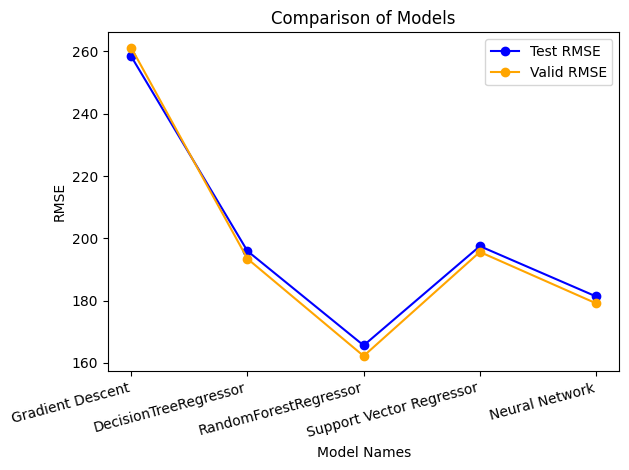

In [48]:
gd_test_rmse3, gd_val_rmse3 = compute_error(x_test_new, y_test, e3w , e3b)[0], compute_error(x_val_new, y_val, e3w , e3b)[0]
tree_test_rmse3, tree_val_rmse3 = compute_errors(y_test, tree_pred3)[0], compute_errors(y_val, tree_val_pred3)[0]
forest_test_rmse3, forest_val_rmse3 = compute_errors(y_test, forest_pred3)[0], compute_errors(y_val, forest_val_pred3)[0]
svr_test_rmse3, svr_val_rmse3 = compute_errors(y_test, svr_pred3)[0], compute_errors(y_val, svr_val_pred3)[0]

test_rmses3 = [gd_test_rmse3, tree_test_rmse3, forest_test_rmse3, svr_test_rmse3, nn_test_rmse3]
val_rmses3 = [gd_val_rmse3, tree_val_rmse3, forest_val_rmse3, svr_val_rmse3, nn_val_rmse3]

plot(model_names, test_rmses3, val_rmses3)

In [49]:
alpha = 0.08666666666666667
run_iter = 4000
w4, b4 = w1, b1

e4w, e4b, train_rmses4, val_rmses4 = gradient_descent(x_train, x_val, y_train, y_val, w4, b4, alpha, run_iter)

In [51]:
evaluate_name = ['RMSE', 'R^2']
print('Train Error')
for name, error in zip(evaluate_name, compute_error(x_train, y_train, e4w , e4b)):
    print(f'{name} : {error:.6f}')
print('--------------------------------')
print('Test Error')
for name, error in zip(evaluate_name, compute_error(x_test, y_test, e4w , e4b)):
    print(f'{name} : {error:.6f}')
print('--------------------------------')
print('Valid Error')
for name, error in zip(evaluate_name, compute_error(x_val, y_val, e4w , e4b)):
    print(f'{name} : {error:.6f}')

Train Error
RMSE : 240.151764
R^2 : 0.706531
--------------------------------
Test Error
RMSE : 232.260795
R^2 : 0.727013
--------------------------------
Valid Error
RMSE : 235.518134
R^2 : 0.719232


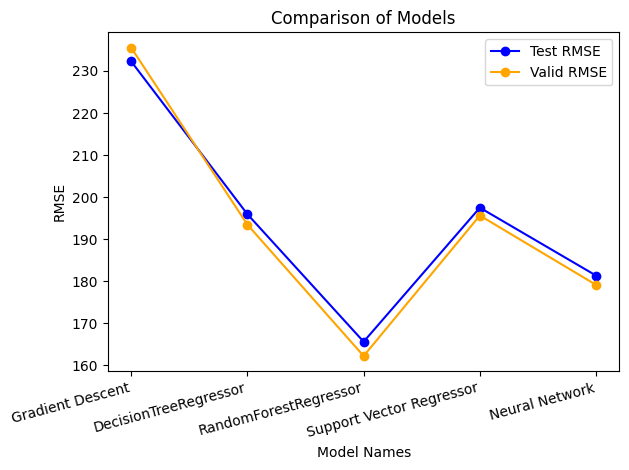

In [52]:
gd_test_rmse4, gd_val_rmse4 = compute_error(x_test, y_test, e4w , e4b)[0], compute_error(x_val, y_val, e4w , e4b)[0]
tree_test_rmse3, tree_val_rmse3 = compute_errors(y_test, tree_pred3)[0], compute_errors(y_val, tree_val_pred3)[0]
forest_test_rmse3, forest_val_rmse3 = compute_errors(y_test, forest_pred3)[0], compute_errors(y_val, forest_val_pred3)[0]
svr_test_rmse3, svr_val_rmse3 = compute_errors(y_test, svr_pred3)[0], compute_errors(y_val, svr_val_pred3)[0]

test_rmses4 = [gd_test_rmse4, tree_test_rmse3, forest_test_rmse3, svr_test_rmse3, nn_test_rmse3]
val_rmses4 = [gd_val_rmse4, tree_val_rmse3, forest_val_rmse3, svr_val_rmse3, nn_val_rmse3]

plot(model_names, test_rmses4, val_rmses4)

In [53]:
#valid_labels = valid_labels.to_numpy()
valid_labels_for_gd = StandardScaler().fit(valid_labels).transform(valid_labels)

In [54]:
valid_gd_rmse, valid_gd_r2 = compute_error(valid_labels_for_gd, valid_target, e4w, e4b)[0], compute_error(valid_labels_for_gd, valid_target, e4w, e4b)[1]
valid_gd_rmse, valid_gd_r2

(307.26905308898347, 0.6284417754048994)

In [55]:
selected_columns = valid_labels.columns[featue_importances >= median_featue_importances]
valid_labels = valid_labels[selected_columns]

In [56]:
valid_labels = StandardScaler().fit(valid_labels).transform(valid_labels)

In [57]:
valid_tree_pred = tree_model3.predict(valid_labels)
valid_tree_rmse, valid_tree_r2 = compute_errors(valid_target, valid_tree_pred)[0], compute_errors(valid_target, valid_tree_pred)[1]
valid_tree_rmse, valid_tree_r2

(303.90652701183905, 0.6365293982326314)

In [58]:
valid_forest_pred = forest_model3.predict(valid_labels)
valid_forest_rmse, valid_forest_r2 = compute_errors(valid_target, valid_forest_pred)[0], compute_errors(valid_target, valid_forest_pred)[1]
valid_forest_rmse, valid_forest_r2

(279.5237326749564, 0.6925131063089547)

In [59]:
valid_svr_pred = svr_model3.predict(valid_labels)
valid_svr_rmse, valid_svr_r2 = compute_errors(valid_target, valid_svr_pred)[0], compute_errors(valid_target, valid_svr_pred)[1]
valid_svr_rmse, valid_svr_r2

(287.1869148614686, 0.6754224099640127)

In [60]:
valid_labels_for_nn = valid_labels_for_gd
valid_labels_for_nn = torch.tensor(valid_labels_for_nn, dtype=torch.float32)

In [62]:
valid_labels_for_nn.shape, valid_target.shape

(torch.Size([15916, 24]), (15916,))

In [63]:
nn_model1.eval()
with torch.inference_mode():
    predict = nn_model1(valid_labels_for_nn)

predict_np = predict.numpy()
vallid_target = valid_target.to_numpy()
scaler_y = StandardScaler().fit(vallid_target.reshape(-1, 1))
predict_np = scaler_y.inverse_transform(predict_np)
valid_nn_rmse = np.sqrt(mean_squared_error(vallid_target, predict_np))
valid_nn_r2 = r2_score(vallid_target, predict_np)
valid_nn_rmse, valid_nn_r2

(245.03559735184342, 0.7637087735926418)

In [64]:
model_names = ['Gradient Descent', 'DecisionTreeRegressor', 'RandomForestRegressor', 'Support Vector Regressor', 'Neural Network']
model_rmse = [valid_gd_rmse, valid_tree_rmse, valid_forest_rmse, valid_svr_rmse, valid_nn_rmse]
model_r2 = [valid_gd_r2, valid_tree_r2, valid_forest_r2, valid_svr_r2, valid_nn_r2]

C:\Users\asd00\AppData\Local\Temp\ipykernel_24248\1131749244.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='RMSE', data=data, ax=ax1, palette='Blues_d')
C:\Users\asd00\AppData\Local\Temp\ipykernel_24248\1131749244.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
C:\Users\asd00\AppData\Local\Temp\ipykernel_24248\1131749244.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Model', y='R2', data=data, ax=ax2, palette='Greens_d')
C:\Users\asd00\AppData\Local\Temp\ipykernel_24248\1131749244.py:24: UserWarning: set_ti

<Figure size 1200x1000 with 0 Axes>

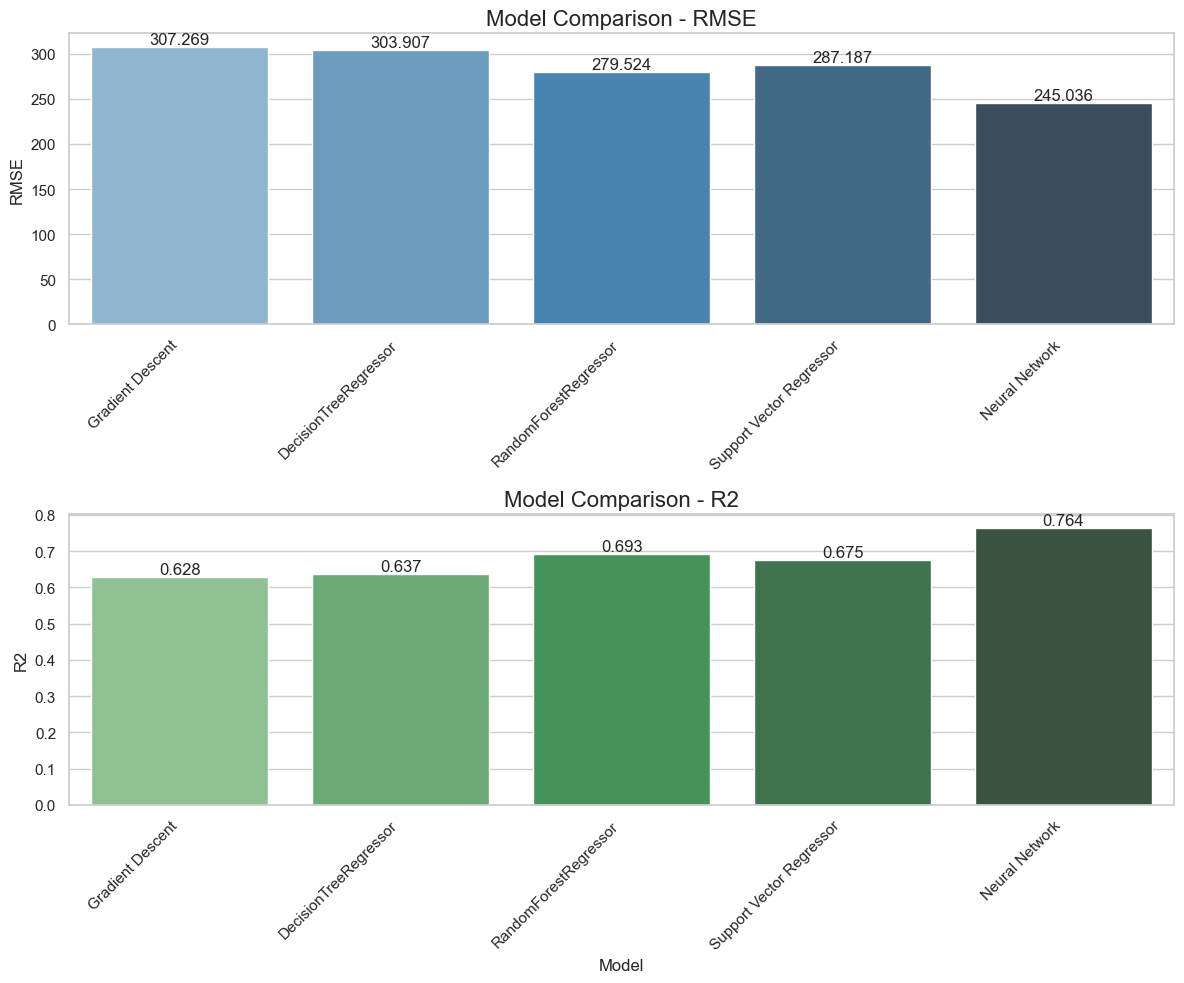

In [65]:
data = pd.DataFrame({
    'Model': model_names,
    'RMSE': model_rmse,
    'R2': model_r2
})


sns.set(style="whitegrid")
plt.figure(figsize=(12, 10))


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))

sns.barplot(x='Model', y='RMSE', data=data, ax=ax1, palette='Blues_d')
ax1.set_title('Model Comparison - RMSE', fontsize=16)
ax1.set_xlabel('')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')

for i, v in enumerate(data['RMSE']):
    ax1.text(i, v, f'{v:.3f}', ha='center', va='bottom')

sns.barplot(x='Model', y='R2', data=data, ax=ax2, palette='Greens_d')
ax2.set_title('Model Comparison - R2', fontsize=16)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

for i, v in enumerate(data['R2']):
    ax2.text(i, v, f'{v:.3f}', ha='center', va='bottom')

plt.tight_layout()

plt.show()

C:\Users\asd00\AppData\Local\Temp\ipykernel_24248\3940640364.py:17: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')
C:\Users\asd00\AppData\Local\Temp\ipykernel_24248\3940640364.py:25: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')


<Figure size 1200x1000 with 0 Axes>

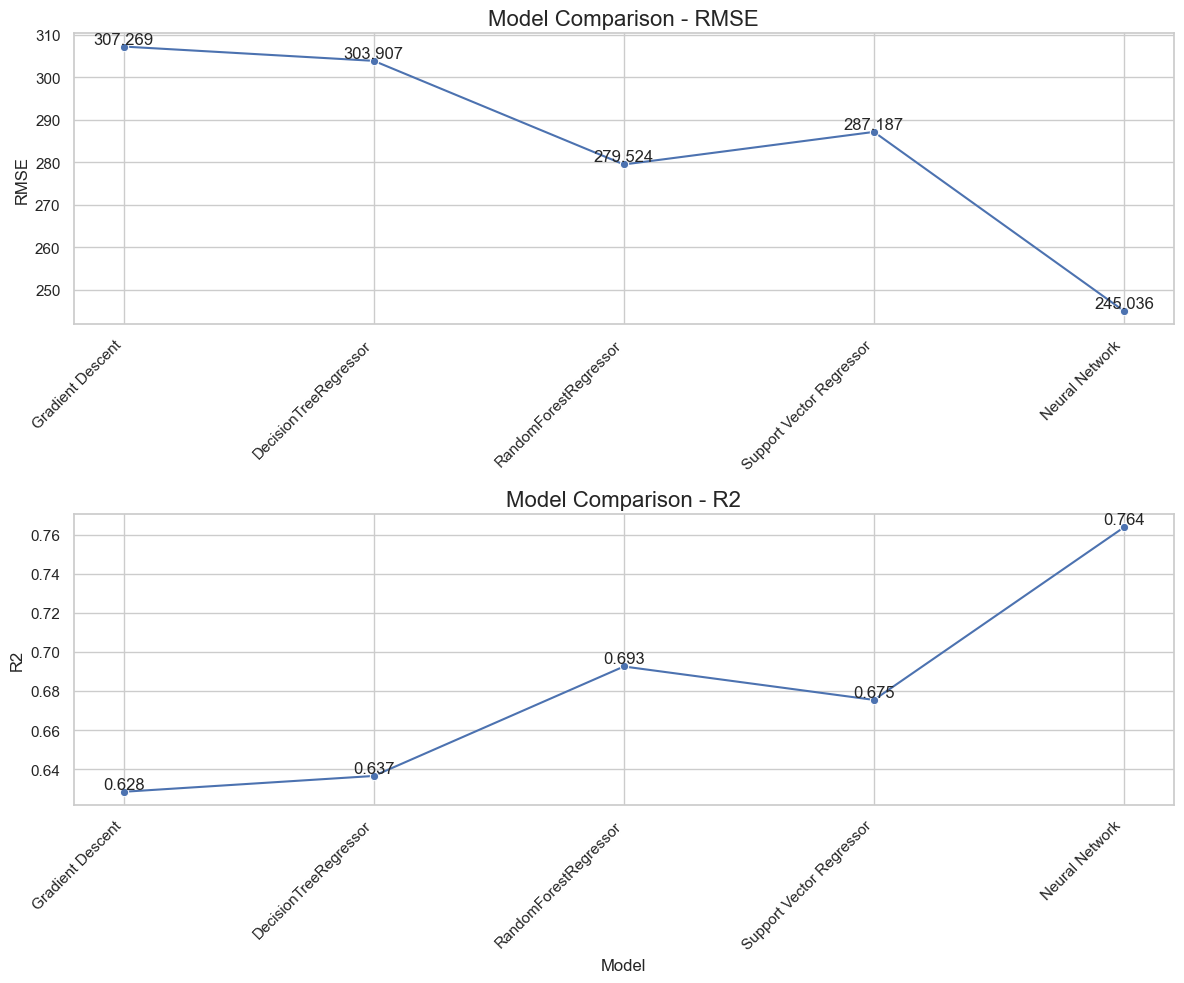

In [66]:
data = pd.DataFrame({
    'Model': model_names,
    'RMSE': model_rmse,
    'R2': model_r2
})

sns.set(style="whitegrid")
plt.figure(figsize=(12, 10))


fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10))


sns.lineplot(x='Model', y='RMSE', data=data, ax=ax1, marker='o')
ax1.set_title('Model Comparison - RMSE', fontsize=16)
ax1.set_xlabel('')
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45, ha='right')


for i, v in enumerate(data['RMSE']):
    ax1.text(i, v, f'{v:.3f}', ha='center', va='bottom')

sns.lineplot(x='Model', y='R2', data=data, ax=ax2, marker='o')
ax2.set_title('Model Comparison - R2', fontsize=16)
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')


for i, v in enumerate(data['R2']):
    ax2.text(i, v, f'{v:.3f}', ha='center', va='bottom')


plt.tight_layout()


plt.show()